### Key properties of the network
- Number of nodes
- Number of edges
- triangles 
- SCC
- degree distribution
- powerlaw
- clustering coefficient


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import operator
import collections
import powerlaw


from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx



pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

### Construct the network in NetworkX

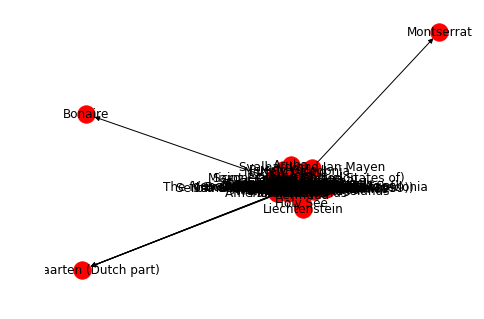

In [2]:
df = pd.read_csv("../data/unhcr_time_series_normalized.csv")
from_to_values = df.groupby(["origin",'destination'])['value'].sum().reset_index().sort_values("value", ascending=False)
#print(from_to_values)

edge_list=from_to_values[['origin', 'destination', 'value']]
edges = list(map(tuple, list(edge_list.values)))
DG = nx.DiGraph()
DG.add_weighted_edges_from(edges)

#print(edges)
nx.draw(DG,with_labels=True)

plt.show()

In [3]:
num_nodes = len(DG)
e_max = num_nodes*(num_nodes-1)/2
num_edges = DG.number_of_edges()
deg_k = num_edges/num_nodes
print("num_nodes: ", num_nodes)
print("num_edges: ", num_edges)
print("e_max: ", e_max)
print("deg_k: ", deg_k)


num_nodes:  220
num_edges:  9274
e_max:  24090.0
deg_k:  42.154545454545456


Number of nodes will not grow in this network, because number of countries is fixed. However, we can see that E << Emax, and k << N-1. We have a sparse network, similar to most real world networks.

#### We using a undirected graph to find triangles in the graph. Country is key and value is how many triangles the country is in

In [4]:
G = nx.Graph()
G.add_weighted_edges_from(edges)

tri = nx.triangles(G)
sorted_tri = sorted(tri.items(), key=operator.itemgetter(1), reverse=True)

print(sorted_tri)


[('Canada', 7663), ('Germany', 7662), ('United States of America', 7656), ('United Kingdom', 7202), ('Australia', 6979), ('Sweden', 6879), ('Turkey', 6661), ('Syrian Arab Rep.', 6640), ('Brazil', 6630), ('Ukraine', 6569), ('France', 6482), ('Switzerland', 6478), ('Belgium', 6392), ('Egypt', 6173), ('Somalia', 5989), ('Norway', 5843), ('Austria', 5827), ('Sudan', 5801), ('South Africa', 5794), ('Nigeria', 5753), ('Ireland', 5711), ('Netherlands', 5702), ('Italy', 5665), ('Cameroon', 5570), ('Iraq', 5567), ('Ethiopia', 5562), ('Russian Federation', 5525), ("Côte d'Ivoire", 5456), ('Finland', 5406), ('Argentina', 5368), ('Dem. Rep. of the Congo', 5311), ('Eritrea', 5311), ('Morocco', 5283), ('Spain', 5204), ('India', 5121), ('Ecuador', 5031), ('Congo', 5015), ('Liberia', 4995), ('Pakistan', 4990), ('China', 4898), ('Ghana', 4886), ('Denmark', 4861), ('Yemen', 4836), ('Israel', 4809), ('Poland', 4797), ('Lebanon', 4776), ('Bulgaria', 4775), ('Rep. of Korea', 4771), ('Hungary', 4767), ('Gre

In [5]:
strongly_connected_components = nx.strongly_connected_components(DG)
core_components = [c for c in sorted(strongly_connected_components, key=len, reverse=True) if len(c) > 1]
print("Num Strongly Connected Components = %s" % (len(core_components)))
print(core_components)

Num Strongly Connected Components = 1
[{'Malta', 'Lithuania', 'Turkey', 'Panama', 'Aruba', 'Congo', 'Chad', 'Swaziland', 'Rep. of Moldova', 'Mongolia', 'Mauritius', 'Myanmar', 'Indonesia', 'Syrian Arab Rep.', 'Namibia', 'Kuwait', 'Burkina Faso', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Iran (Islamic Rep. of)', 'Peru', 'Madagascar', 'Lebanon', 'Guatemala', 'Samoa', 'France', 'Nauru', 'Bosnia and Herzegovina', 'Senegal', 'Iraq', 'Armenia', 'Rwanda', 'Dominican Rep.', 'United States of America', 'Chile', 'Jamaica', 'Barbados', 'Cameroon', 'Zambia', 'Kyrgyzstan', 'Anguilla', 'Haiti', 'Guinea', 'Cambodia', 'Azerbaijan', 'India', "Côte d'Ivoire", 'Benin', 'Brazil', 'Spain', 'Ghana', 'Botswana', 'Georgia', 'Algeria', 'Sweden', 'Morocco', 'Costa Rica', 'Burundi', 'Libya', 'Norway', 'United Rep. of Tanzania', 'Nigeria', 'Afghanistan', 'Italy', 'Micronesia (Federated States of)', 'El Salvador', 'Bahamas', 'Rep. of Korea', 'Seychelles', 'United Kingdom', 'Eritrea', 'Tunisia', 'Canada', 

We found one SCC but it appears to contain all nodes. We need to identify a meaningful way to draw links between countries instead of drawing all edges 

### Degree Distribution
We examine inflow and outflow of nodes by summing the edge weights. In our case, this means we examine the distribution of refugees based on their origin and desintations

In [6]:
inflow = df.groupby(['destination'])['value'].sum().reset_index().sort_values("value", ascending=False)
inflow_values = inflow.value.tolist()


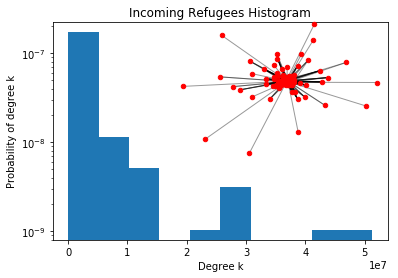

In [7]:
plt.hist(inflow_values, density=True, log=True)
plt.title("Incoming Refugees Histogram")
plt.ylabel("Probability of degree k")
plt.xlabel("Degree k")

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()


- This now represents what we were trying to achieve with power law. We should instead consider when to draw edges between two countries, so we analyze degrees instead of flow 

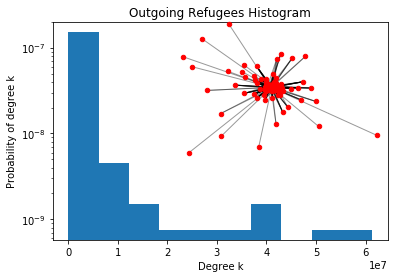

In [8]:
outflow = df.groupby(['origin'])['value'].sum().reset_index().sort_values("value", ascending=False)
outflow_values = outflow.value.tolist()

plt.hist(outflow_values, density=True, log=True)
plt.title("Outgoing Refugees Histogram")
plt.ylabel("Probability of degree k")
plt.xlabel("Degree k")

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()


#### Powerlaw graphs for incoming and outgoing refugees based on number of refugees.

<Figure size 1296x576 with 0 Axes>

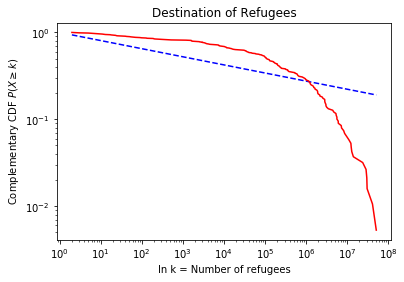

alpha=  1.0933669066316518   sigma=  0.006791443127673315


In [9]:
plt.figure(figsize=(18,8));

#lables = [r'$x^{-( \alpha-1)}, \alpha = 1.11$', "Empirical data"]


fit = powerlaw.Fit(np.array(inflow_values)+1,xmin=1,discrete=False)
fit.power_law.plot_ccdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_ccdf( color= 'r')
plt.title('Destination of Refugees')
plt.xlabel('In k = Number of refugees')
plt.ylabel('Complementary CDF '+ r'$P(X\geq k)$')
#plt.legend(lables, loc='best', fontsize = 'small')

plt.show()
print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

<Figure size 1296x576 with 0 Axes>

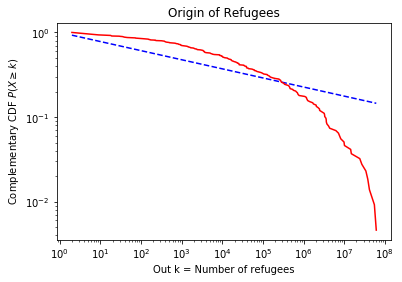

alpha=  1.1075203141462449   sigma=  0.0072989545221011825


In [10]:
plt.figure(figsize=(18,8));

#lables = [r'$x^{-( \alpha-1)}, \alpha = 1.11$', "Empirical data"]


fit = powerlaw.Fit(np.array(outflow_values)+1,xmin=1,discrete=False)
fit.power_law.plot_ccdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_ccdf( color= 'r')
plt.title('Origin of Refugees')
plt.xlabel('Out k = Number of refugees')
plt.ylabel('Complementary CDF '+ r'$P(X\geq k)$')
#plt.legend(lables, loc='best', fontsize = 'small')

plt.show()
print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

#### Clustering coefficient
This would indicate the amount of refugee movements around a certain country. How much are refugees moving around among the country's neighbors? 

In [11]:
print(nx.average_clustering(DG, weight=True))

0.4720264754245707


In [12]:
cc = nx.clustering(DG, weight=True)
sorted_cc = sorted(cc.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_cc)

[('Bermuda', 1.0), ('Cook Islands', 1.0), ('Anguilla', 1.0), ('Saint-Pierre-et-Miquelon', 1.0), ('French Guiana', 0.9166666666666666), ('Andorra', 0.8392857142857143), ('Tuvalu', 0.8333333333333334), ('Kiribati', 0.8), ('Saint Lucia', 0.7777777777777778), ('Brunei Darussalam', 0.7666666666666667), ('Tonga', 0.7545454545454545), ('San Marino', 0.75), ('Maldives', 0.7417582417582418), ('Monaco', 0.7380952380952381), ('Sao Tome and Principe', 0.7361111111111112), ('Saint Vincent and the Grenadines', 0.6964285714285714), ('Antigua and Barbuda', 0.6888888888888889), ('Seychelles', 0.6813186813186813), ('Samoa', 0.6666666666666666), ('Aruba', 0.6666666666666666), ('Saint Kitts and Nevis', 0.6636363636363637), ('China, Macao SAR', 0.6602564102564102), ('Oman', 0.6497524752475248), ('Bahrain', 0.6464285714285715), ('Dominica', 0.6458333333333334), ('Qatar', 0.6393088552915767), ('Vanuatu', 0.6333333333333333), ("Lao People's Dem. Rep.", 0.6286231884057971), ('Barbados', 0.6285714285714286), ('